### Model: K-Nearest Neighbors

- Works by finding the k closest data points or neighbors to a given input and then makes a prediction based on the majority class for classification

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.model_selection import cross_val_score

In [13]:
def apply_lag_features(merged_df):
    # add previous one-day values
    merged_df["prev1_open"] = merged_df["Open"].shift(1)
    merged_df["prev1_close"] = merged_df["Close"].shift(1)

    # add previous two-day values
    merged_df["prev2_open"] = merged_df["Open"].shift(2)
    merged_df["prev2_close"] = merged_df["Close"].shift(2)

    # previous 1 day sentiment
    merged_df["prev1_sentiment_compound"] = merged_df["sentiment_compound"].shift(1)

    # previous 2 day sentiment
    merged_df["prev2_sentiment_compound"] = merged_df["sentiment_compound"].shift(2)

    # previous 1 day volume
    merged_df["prev1_volume"] = merged_df["Volume"].shift(1)

    # previous 2 day volume
    merged_df["prev2_volume"] = merged_df["Volume"].shift(2)

    
    return merged_df

In [14]:
def drop_na(merged_df):
    merged_df = merged_df.dropna()
    merged_df.reset_index(drop=True, inplace=True)
    return merged_df

In [15]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((np.array(point1) - np.array(point2))**2))

def k_nearest_neighbors_model(df):
    features = [
        'Open', 'Close', 'Volume', 'sentiment_compound', 'prev1_open', 'prev1_close','prev1_volume',
        'prev2_volume', 'prev2_open', 'prev2_close', 'prev1_sentiment_compound',
        'prev2_sentiment_compound'
    ]

    X = df[features]
    y = df['target'].astype(float)  # goal is to predict the next day's closing price (classification)

    valid_idx = np.isin(y, [-1, 1]) # removing any row that does not have -1 or 1 as target
    X = X[valid_idx]
    y = y[valid_idx]

    # scale features in order to avoid certain features from dominating others
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

In [16]:
stocks = ['AAPL', 'GOOG', 'INTC', 'META', 'MSFT']

for stock in stocks:
    print(stock)
    stock_finance_df = pd.read_csv(f'../{stock} Data/{stock}_finance_data.csv')
    stock_sentiment_df = pd.read_csv(f'../{stock} Data/{stock}_avg_sentiment_data.csv')
    merged_stock_df = pd.merge(stock_finance_df, stock_sentiment_df, on='Date', how='inner')
    merged_stock_df = apply_lag_features(merged_stock_df)
    merged_stock_df = drop_na(merged_stock_df)
    print(f"Results for {stock}:")
    print(f"Num of rows, ", len(merged_stock_df))
    k_nearest_neighbors_model(merged_stock_df)
    print("\n")


AAPL
Results for AAPL:
Num of rows,  250
Accuracy: 0.48


GOOG
Results for GOOG:
Num of rows,  236
Accuracy: 0.5416666666666666


INTC
Results for INTC:
Num of rows,  131
Accuracy: 0.5769230769230769


META
Results for META:
Num of rows,  217
Accuracy: 0.5227272727272727


MSFT
Results for MSFT:
Num of rows,  250
Accuracy: 0.5




Text(0.5, 1.0, 'K-Nearest Neighbors: K Value vs Accuracy for META')

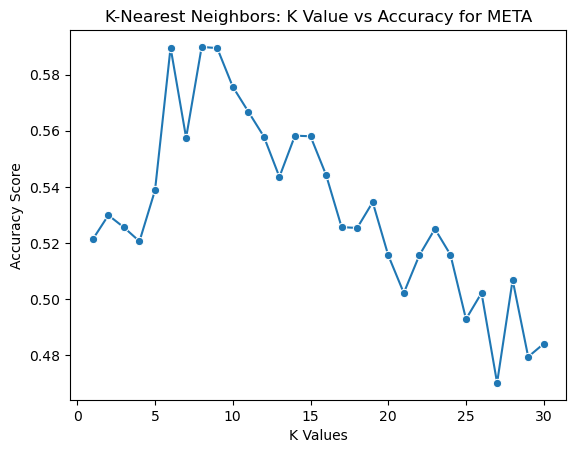

In [22]:
k_values = [i for i in range (1,31)]
scores = []

stock_finance_df = pd.read_csv(f'../META Data/META_finance_data.csv')
stock_sentiment_df = pd.read_csv(f'../META Data/META_avg_sentiment_data.csv')
merged_stock_df = pd.merge(stock_finance_df, stock_sentiment_df, on='Date', how='inner')
merged_stock_df = apply_lag_features(merged_stock_df)
merged_stock_df = drop_na(merged_stock_df)

features = [
        'Open', 'Close', 'Volume', 'sentiment_compound', 'prev1_open', 'prev1_close','prev1_volume',
        'prev2_volume', 'prev2_open', 'prev2_close', 'prev1_sentiment_compound',
        'prev2_sentiment_compound'
    ]

X = merged_stock_df[features]
y = merged_stock_df['target'].astype(float)  # goal is to predict the next day's closing price (classification)

valid_idx = np.isin(y, [-1, 1]) # removing any row that does not have -1 or 1 as target
X = X[valid_idx]
y = y[valid_idx]

scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
plt.title("K-Nearest Neighbors: K Value vs Accuracy for META")